# larger datasets

In [12]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import zarr

from utils import remove_all_ticks_and_labels

# import MNIST dataset

In [72]:
# params
description = {
    # 'model_name': 'dendritic-mnist',
    'model_name': 'fc-mnist',
    'model_number': 2,
    'num_steps': 100,
    'forward_schedule': 'sine',
    'batch_size': 256,
    # 'hidden_cfg': [8, 8, 7, 7],
    'hidden_cfg': 1024,
    'num_ambient_dims': 28 * 28,
    'num_epochs': 2e2,
    'manifold_type': 'mnist',
    'lr': 3e-4,
    'optimizer': 'Adam',
    'classes': [0, 1, 2],
}

In [73]:
import torch
from torchvision import datasets, transforms
mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')

mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                ]))

# ------------------------------- select digits ------------------------------ #
# indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2)
# mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=description['batch_size'], shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(mnist_dir, train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args['test_batch_size'], shuffle=True, **kwargs)

In [75]:
def train(num_epochs, model, train_loader, num_steps, optimizer, tb, device):
    from torch.autograd import Variable
    from prior_utils import calculate_loss
    
    for epoch in tqdm(range(1, int(num_epochs) + 1)):
        # start training    
        for batch_idx, (data, target) in enumerate(train_loader):
            
            data, target = data.to(device), target.to(device)
            # data, target = Variable(data), Variable(target)
            
            # zero the gradients
            optimizer.zero_grad()
            
            # compute the loss
            # loss = calculate_loss(model, data, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            loss = calculate_loss(model, data, n_steps=100, forward_schedule='sine', norm='l2', device=device)
            
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
            
            # write to tensorboard
            tb.add_scalar('Loss', loss.item(), epoch+batch_idx)
        
        return model

In [76]:
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

from models import VariableDendriticCircuit, FullyConnectedNetwork
# model = VariableDendriticCircuit(hidden_cfg=description['hidden_cfg'], 
#                                 num_in=description['num_ambient_dims'], 
#                                 num_out=description['num_ambient_dims'], 
#                                 bias=True)

model = FullyConnectedNetwork(n_dim_data=description['num_ambient_dims'] ,num_hidden=description['hidden_cfg'])
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=description['lr'])
# optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

run_dir = os.path.join(base_dir, 'demos/runs', f'{description["model_name"]}_{description["model_number"]}')
tb = SummaryWriter(run_dir)
start_time = time.time()

model.train()
model = train(epoch, model, train_loader, description['num_steps'], optimizer, tb, device)

from utils import save_model_weights
save_model_weights(model, description['model_name'], description['model_number'])
tb.flush()

Using device: cuda


  0%|          | 0/200 [00:00<?, ?it/s]

NameError: name 'model_name' is not defined

In [88]:
# load model weights
model = FullyConnectedNetwork(n_dim_data=description['num_ambient_dims'] ,num_hidden=description['hidden_cfg'])
from utils import load_model_weights
model = load_model_weights(model, description['model_name'], 2, device)
model = model.to(device)
model.eval()

model loaded!


FullyConnectedNetwork(
  (condlin1): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=785, out_features=512, bias=True)
  )
  (condlin2): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=513, out_features=512, bias=True)
  )
  (condlin3): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=513, out_features=512, bias=True)
  )
  (linear): Linear(in_features=512, out_features=784, bias=True)
  (nonlin): ReLU()
  (sigmoid): Sigmoid()
)

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

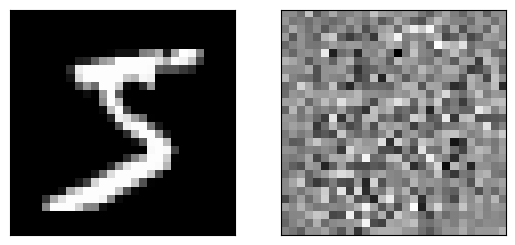

In [89]:
# generate samples from the model
from prior_utils import p_sample_loop

shape = (1, description['num_ambient_dims'])
x_hat = p_sample_loop(model, shape, description['num_steps'], device=device, init_x=None, normalized_beta_schedule=False, schedule='sine')[-1]
x_hat = x_hat.reshape(28, 28).detach().cpu().numpy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(mnist_train.data[0], cmap='gray')
ax[1].imshow(x_hat, cmap='gray')
from utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)